# Satellite data demo

> **Note**: If you wish to save this notebook with any of your changes, please make sure to click on `File` -> `Save a copy in Drive`. All changes will be lost if you close this tab without saving a copy in your Google Drive. All changes made before saving a copy in Drive will be saved in the notebook after you save a copy in Drive. Data is downloaded from the internet and stored in the temporary disk of the environment. This data will be deleted once the session is over.

This demonstration will show you a few key concepts about satellite data and how it can be prepared for featurization. The notebook will guide you through the process of preparing imagery, including:

1. Loading satellite imagery

1. Inspecting image properties

1. Image normalization

1. Image visualization

This notebook will not cover the featurization process. Featurization will be covered in later chapters of the training manual and in demonstration notebooks dedicated to it.

## Environment setup

### Install required packages

Google Colab is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. It comes preinstalled with many packages, including most of the ones we need for this notebook. There are a few additional packages we need to install, which we will do in the next cell.


In [1]:
!pip install rasterio
# !pip install exactextract
# !pip install mapclassify

### Load required packages

Now that we have all of the packages we need, we can load all the ones we will use in this notebook.


In [2]:
import os
import rasterio
import subprocess
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio.features
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.io import MemoryFile
from exactextract import exact_extract
from matplotlib.patches import Rectangle
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection

## Download the ADM0 dataset

In the following example, we create a grid for a GeoDataFrame with a geometry column. The grid will be created for the bounding box of each row, and then cropped to the geometry of that row. First, we load an example of a GeoDataFrame with a geometry column, two countries in this case. We then create a grid for each country and visualize the grid for each country.

This is slightly more practical use case, as it allows for the creation of a grid for multiple locations at once, while still minimizing the number of grid points that are created.


In [3]:
adm_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"

tgo_adm0_fp = f"{adm_url}/TGO/ADM0/geoBoundaries-TGO-ADM0.geojson"

tgo_gdf = gpd.read_file(tgo_adm0_fp)

print(f"Object type: {type(tgo_gdf)}")

print(f"CRS: {tgo_gdf.crs}")

print(f"Shape (row, col): {tgo_gdf.shape}")

tgo_gdf[["shapeType", "shapeISO", "shapeName", "geometry"]]

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
Shape (row, col): (1, 6)


shapeType shapeISO shapeName  \
0      ADM0      TGO      Togo   

                                            geometry  
0  POLYGON ((-0.12366 11.137, -0.1309 11.13846, -...

## Download satellite images

This demonstration uses satellite data from Norway's International Climate and Forest Initiative (NICFI) [Satellite Data Program](https://www.planet.com/nicfi/). This program provides access to Planet Labs high-resolution, analysis-ready mosaics of the world’s tropics. This data is made freely available and the terms of use are provided in their [license agreement](https://university.planet.com/nicfi-resources/1219786)

> More details can be found in the [NICFI User Guide](https://assets.planet.com/docs/NICFI_UserGuidesFAQ.pdf)

This data has already gone extensive pre-processing before being released to the public. This includes normalizing pixel values, masking out cloud, and generating basemaps with coverage in the tropics (+/- 30 degrees of latitude). 

Furthermore, for ease of use here, the basemaps have been clipped to individual grid cells across Togo using the standard MOSAIKS grid at 0.01 degrees. This means there are roughly 46,000 image "chips" (small images clipped from larger ones). This download will pull a zip file from Zenodo and unpack these images into your data directory. 

In [4]:
# Update when data is available
# data_dir = "geofabrik"

# file = "https://download.geofabrik.de/africa/togo-latest-free.shp.zip"

# if not os.path.exists(data_dir):
#     os.makedirs(data_dir, exist_ok=True)

#     !wget -O {data_dir}/togo-latest-free.zip {file}

#     !unzip {data_dir}/togo-latest-free.zip -d {data_dir}

#     !rm {data_dir}/togo-latest-free.zip

# !ls -lhR {data_dir}

## Load a satellite image

Now that we have the satellite images, we load and inspect an image at random.

In [33]:
image_dir = "basemaps/planet_medres_normalized_analytic_2024-12_mosaic/clipped_images"

image_list = os.listdir(image_dir)

np.random.seed(42)

image = str(np.random.choice(image_list))
image = "lon_1.255__lat_8.955.tif"
image

'lon_1.255__lat_8.955.tif'

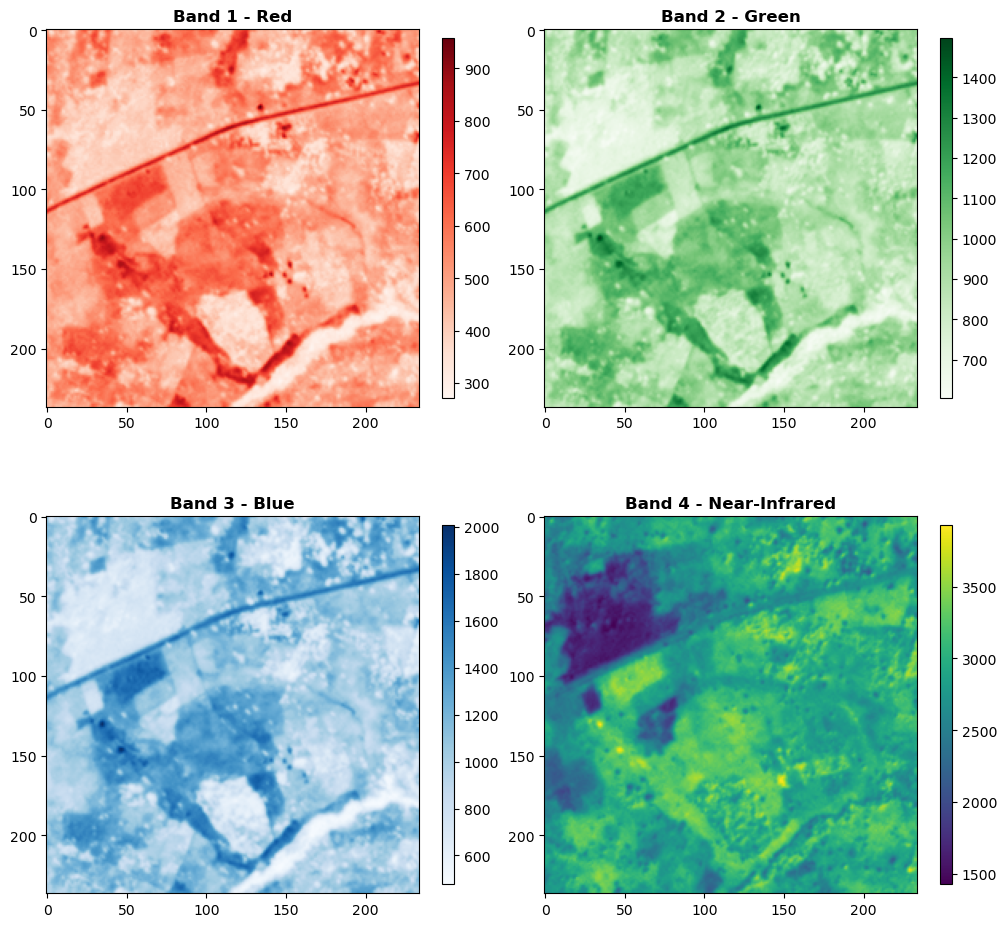

In [34]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the image file
image_path = os.path.join(image_dir, image)
with rasterio.open(image_path) as src:
    # Read all four bands
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue
    band4 = src.read(4)  # NIR

    # Adjust figure size and spacing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust spacing between subplots

    im1 = show(band1, ax=ax1, title="Band 1 - Red", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.7, aspect=30)

    im2 = show(band2, ax=ax2, title="Band 2 - Green", cmap="Greens")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.7, aspect=30)

    im3 = show(band3, ax=ax3, title="Band 3 - Blue", cmap="Blues")
    plt.colorbar(im3.get_images()[0], ax=ax3, shrink=0.7, aspect=30)

    im4 = show(band4, ax=ax4, title="Band 4 - Near-Infrared", cmap="viridis")
    plt.colorbar(im4.get_images()[0], ax=ax4, shrink=0.7, aspect=30)

    # Adjust layout with specified padding
    plt.tight_layout(pad=0.0)
    plt.show()

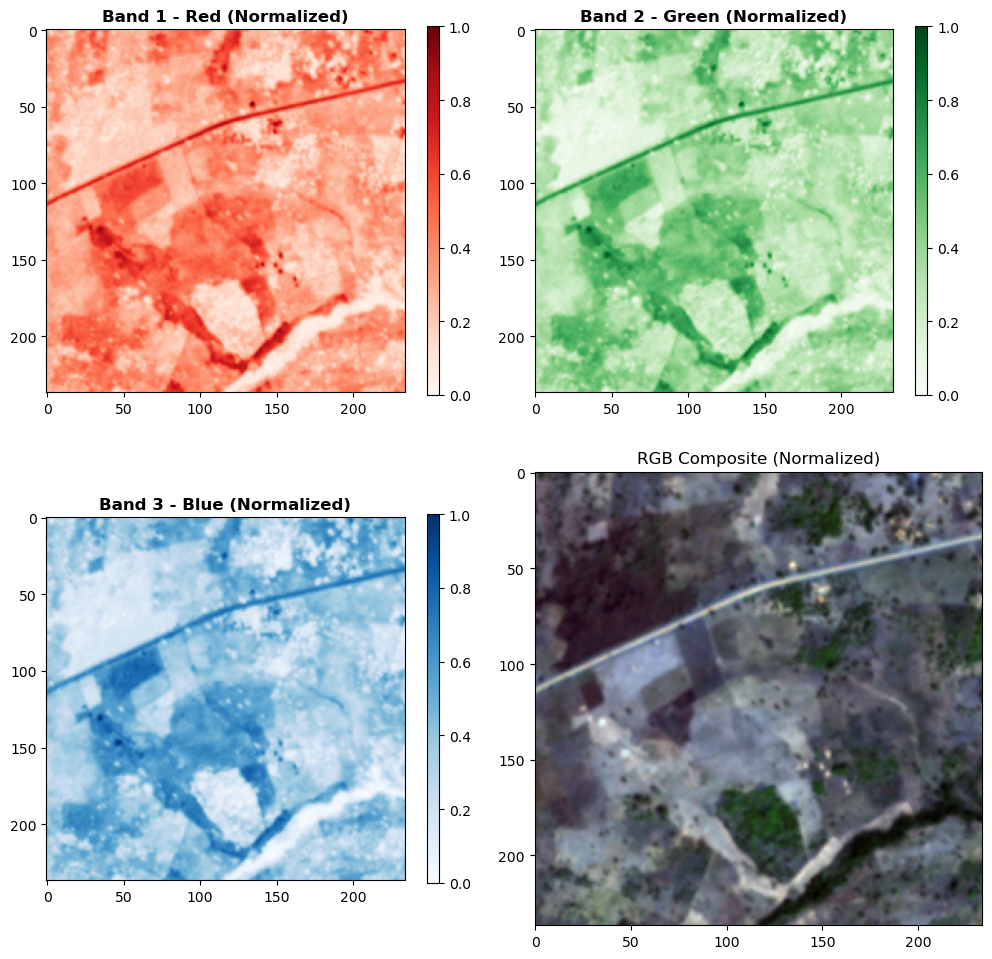

In [35]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Open the image file
image_path = os.path.join(image_dir, image)
with rasterio.open(image_path) as src:
    # Read and normalize each band independently
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())

    # Create RGB composite from normalized bands
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))

    # Create the figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot individual bands using normalized data
    im1 = show(norm_band1, ax=ax1, title="Band 1 - Red (Normalized)", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.8, aspect=30)

    im2 = show(norm_band2, ax=ax2, title="Band 2 - Green (Normalized)", cmap="Greens")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.8, aspect=30)

    im3 = show(norm_band3, ax=ax3, title="Band 3 - Blue (Normalized)", cmap="Blues")
    plt.colorbar(im3.get_images()[0], ax=ax3, shrink=0.8, aspect=30)

    # Plot RGB composite
    ax4.imshow(rgb)
    ax4.set_title("RGB Composite (Normalized)")
    ax4.axis("on")

    plt.tight_layout(pad=1.0)
    plt.show()

https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/

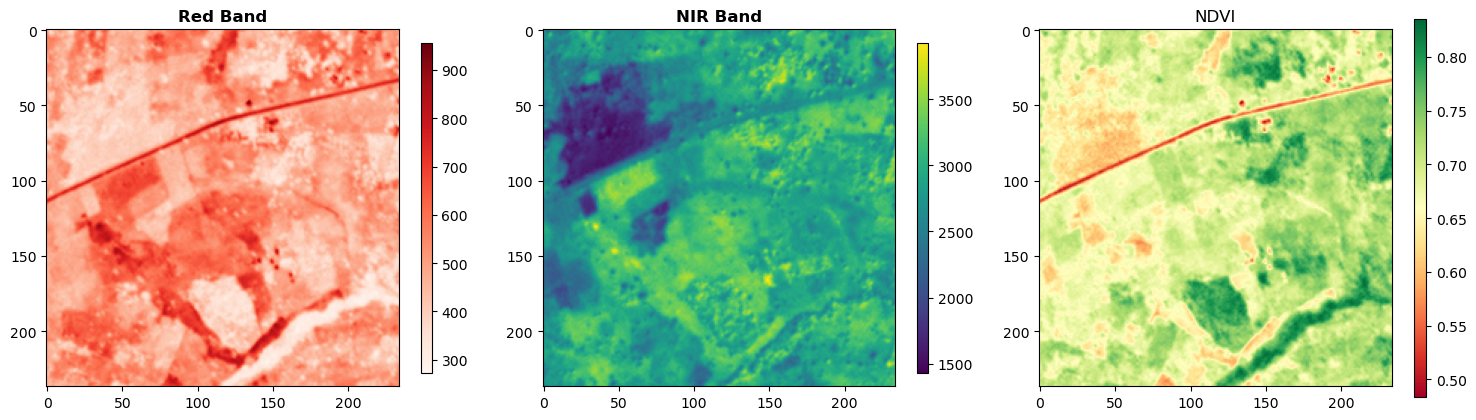

In [36]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Open the image file
image_path = os.path.join(image_dir, image)
with rasterio.open(image_path) as src:
    # Read the red and NIR bands
    red = src.read(1)  # Red
    nir = src.read(4)  # NIR

    # Calculate NDVI using raw values
    ndvi = (nir - red) / (nir + red + 1e-10)

    # ndvi_normalized = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min()) * 2 - 1

    # Normalize bands only for display purposes
    norm_red = (red - red.min()) / (red.max() - red.min())
    norm_nir = (nir - nir.min()) / (nir.max() - nir.min())

    # Create the figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.3)

    # Plot Red band
    im1 = show(red, ax=ax1, title="Red Band", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.7, aspect=30)

    # Plot NIR band
    im2 = show(nir, ax=ax2, title="NIR Band", cmap="viridis")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.7, aspect=30)

    # Plot NDVI
    im3 = ax3.imshow(ndvi, cmap="RdYlGn")
    ax3.set_title("NDVI")
    plt.colorbar(im3, ax=ax3, shrink=0.8, aspect=30)

    plt.tight_layout(pad=1.0)
    plt.show()

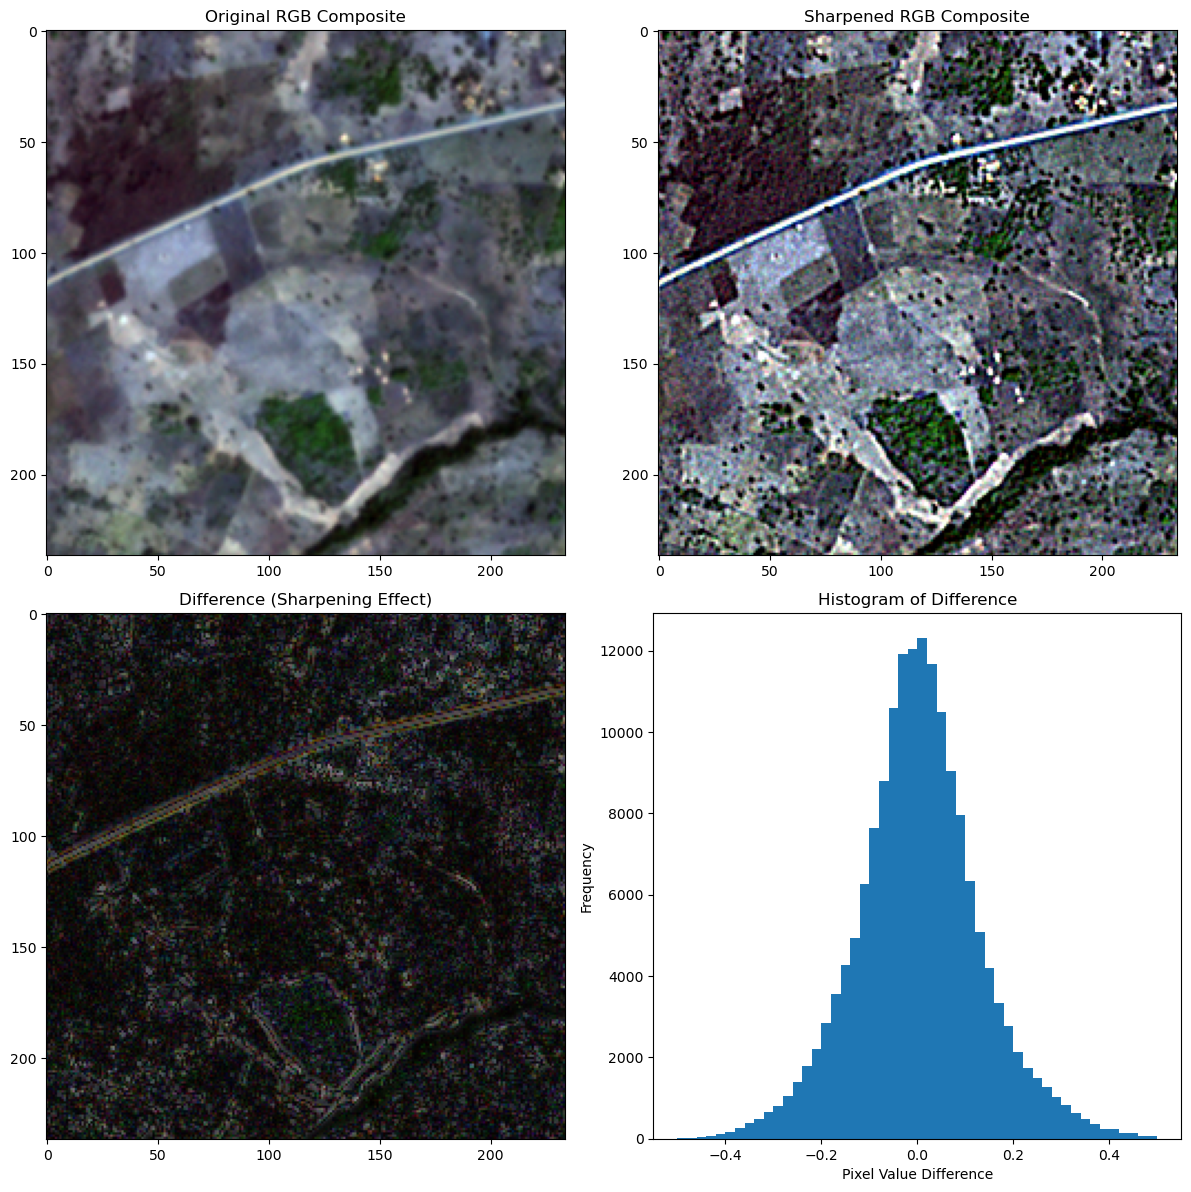

In [58]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d


def sharpen_image(image, kernel_size=3, strength=1.0):
    kernel = np.array(
        [
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0],
        ]
    )  # * strength / 10
    kernel = np.array(
        [
            [-1, -1, -1],
            [-1, 9, -1],
            [-1, -1, -1],
        ]
    )  # * strength / 9
    # Apply kernel to each band
    if len(image.shape) == 3:
        sharpened = np.zeros_like(image)
        for i in range(image.shape[2]):
            sharpened[:, :, i] = convolve2d(
                image[:, :, i], kernel, mode="same", boundary="symm"
            )
    else:
        sharpened = convolve2d(image, kernel, mode="same", boundary="symm")

    # Clip values to valid range
    return np.clip(sharpened, 0, 1)


# Open the image file
image_path = os.path.join(image_dir, image)
with rasterio.open(image_path) as src:
    # Read and normalize each band independently
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())

    # Create RGB composite from normalized bands
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))

    # Create sharpened version
    rgb_sharpened = sharpen_image(rgb, strength=5)

    # Create the figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot original RGB composite
    ax1.imshow(rgb)
    ax1.set_title("Original RGB Composite")
    ax1.axis("on")

    # Plot sharpened RGB composite
    ax2.imshow(rgb_sharpened)
    ax2.set_title("Sharpened RGB Composite")
    ax2.axis("on")

    # Plot difference between original and sharpened
    difference = rgb_sharpened - rgb
    ax3.imshow(np.abs(difference), cmap="grey")
    ax3.set_title("Difference (Sharpening Effect)")
    ax3.axis("on")

    # Plot histogram of difference
    ax4.hist(difference.ravel(), bins=50, range=(-0.5, 0.5))
    ax4.set_title("Histogram of Difference")
    ax4.set_xlabel("Pixel Value Difference")
    ax4.set_ylabel("Frequency")

    plt.tight_layout(pad=1.0)
    plt.show()